In [1]:
## Load functions


# define spherical python functions
def angle_through_center(p1, p2):
    """Angle at center of sphere between two points on the surface of the sphere.
    Positions are given as (latitude,longitude) tuples measured in degrees."""
    phi1 = numpy.deg2rad( p1[0] )
    phi2 = numpy.deg2rad( p2[0] )
    dphi_2 = 0.5 * ( phi2 - phi1 )
    dlambda_2 = 0.5 * numpy.deg2rad( p2[1] - p1[1] )
    a = numpy.sin( dphi_2 )**2 + numpy.cos( phi1 ) * numpy.cos( phi2 ) * ( numpy.sin( dlambda_2 )**2 )
    c = 2. * numpy.arctan2( numpy.sqrt(a), numpy.sqrt( 1. - a ) )
    return c

def quad_area(lat, lon):
    """Returns area of spherical quad (bounded by great arcs)."""
    # x,y,z are 3D coordinates
    d2r = numpy.deg2rad(1.)
    x = numpy.cos(d2r * lat) * numpy.cos(d2r * lon)
    y = numpy.cos(d2r * lat) * numpy.sin(d2r * lon)
    z = numpy.sin(d2r * lat)
    c0 = (x[ :-1, :-1], y[ :-1, :-1], z[ :-1, :-1])
    c1 = (x[ :-1,1:  ], y[ :-1,1:  ], z[ :-1,1:  ])
    c2 = (x[1:  ,1:  ], y[1:  ,1:  ], z[1:  ,1:  ])
    c3 = (x[1:  , :-1], y[1:  , :-1], z[1:  , :-1])
    a0 = angle_between(c1, c0, c2)
    a1 = angle_between(c2, c1, c3)
    a2 = angle_between(c3, c2, c0)
    a3 = angle_between(c0, c3, c1)
    return a0 + a1 + a2 + a3 - 2. * numpy.pi

def angle_between(v1, v2, v3):
    """Returns angle v2-v1-v3 i.e betweeen v1-v2 and v1-v3."""
    # vector product between v1 and v2
    px = v1[1] * v2[2] - v1[2] * v2[1]
    py = v1[2] * v2[0] - v1[0] * v2[2]
    pz = v1[0] * v2[1] - v1[1] * v2[0]
    # vector product between v1 and v3
    qx = v1[1] * v3[2] - v1[2] * v3[1]
    qy = v1[2] * v3[0] - v1[0] * v3[2]
    qz = v1[0] * v3[1] - v1[1] * v3[0]

    ddd = (px * px + py * py + pz * pz) * (qx * qx + qy * qy + qz * qz)
    ddd = (px * qx + py * qy + pz * qz) / numpy.sqrt(ddd)
    angle = numpy.arccos( ddd )
    return angle


def generate_regional_spherical(lon0, lon_span, lat0, lat_span, tilt, refine):
    """Generate a regional grid centered at (lon0,lat0) with spans of (lon_span,lat_span) and tilted by angle tilt"""
    Ni = int(lon_span*refine)
    Nj = int(lat_span*refine)

    #Generate a mesh at equator centered at (lon0, 0)
    lam_,phi_ = generate_latlon_mesh_centered(Ni,Nj,lon0,lon_span,0.0,lat_span)
    lam_,phi_ = rotate_z_mesh(lam_,phi_, (90.-lon0)*PI_180)  #rotate around z to bring it centered at y axis
    lam_,phi_ = rotate_y_mesh(lam_,phi_,tilt*PI_180)         #rotate around y axis to tilt it as desired
    lam_,phi_ = rotate_x_mesh(lam_,phi_,lat0*PI_180)         #rotate around x to bring it centered at (lon0,lat0)
    lam_,phi_ = rotate_z_mesh(lam_,phi_,-(90.-lon0)*PI_180)  #rotate around z to bring it back

    return lam_,phi_

def rotate_x(x,y,z,theta):
    """Rotate vector (x,y,z) by angle theta around x axis."""
    """Returns the rotated components."""
    cost = np.cos(theta)
    sint = np.sin(theta)
    yp   = y*cost - z*sint
    zp   = y*sint + z*cost
    return x,yp,zp

def rotate_y(x,y,z,theta):
    """Rotate vector (x,y,z) by angle theta around y axis."""
    """Returns the rotated components."""
    cost = np.cos(theta)
    sint = np.sin(theta)
    zp   = z*cost - x*sint
    xp   = z*sint + x*cost
    return xp,y,zp

def rotate_z(x,y,z,theta):
    """Rotate vector (x,y,z) by angle theta around z axis."""
    """Returns the rotated components."""
    cost = np.cos(theta)
    sint = np.sin(theta)
    xp   = x*cost - y*sint
    yp   = x*sint + y*cost
    return xp,yp,z

def pol2cart(lam,phi):
    """Transform a point on globe from Polar (lam,phi) to Cartesian coordinates."""
    """Returns the Cartesian coordinates"""
    lam=lam*PI_180
    phi=phi*PI_180
    x=np.cos(phi)*np.cos(lam)
    y=np.cos(phi)*np.sin(lam)
    z=np.sin(phi)
    return x,y,z
    
def cart2pol(x,y,z):
    """Transform a point on globe from Cartesian (x,y,z) to polar coordinates."""
    """Returns the polar coordinates"""
    lam=np.arctan2(y,x)/PI_180
    phi=np.arctan(z/np.sqrt(x**2+y**2))/PI_180
    return lam,phi

def rotate_z_mesh(lam,phi,theta):
    """Rotate the whole mesh on globe by angle theta around z axis (globe polar axis)."""
    """Returns the rotated mesh."""
    #Bring the angle to be in [-pi,pi] so that atan2 would work
    lam       = np.where(lam>180,lam-360,lam)
    #Change to Cartesian coord
    x,y,z     = pol2cart(lam,phi)
    #Rotate
    xp,yp,zp  = rotate_z(x,y,z,theta)
    #Change back to polar coords using atan2, in [-pi,pi]
    lamp,phip = cart2pol(xp,yp,zp)
    #Bring the angle back to be in [0,2*pi]
    lamp      = np.where(lamp<0,lamp+360,lamp)
    return lamp,phip

def rotate_x_mesh(lam,phi,theta):
    """Rotate the whole mesh on globe by angle theta around x axis (passing through equator and prime meridian.)."""
    """Returns the rotated mesh."""
    #Bring the angle to be in [-pi,pi] so that atan2 would work
    lam       = np.where(lam>180,lam-360,lam)
    #Change to Cartesian coord
    x,y,z     = pol2cart(lam,phi)
    #Rotate
    xp,yp,zp  = rotate_x(x,y,z,theta)
    #Change back to polar coords using atan2, in [-pi,pi]
    lamp,phip = cart2pol(xp,yp,zp)
    #Bring the angle back to be in [0,2*pi]
    lamp      = np.where(lamp<0,lamp+360,lamp)
    return lamp,phip

def rotate_y_mesh(lam,phi,theta):
    """Rotate the whole mesh on globe by angle theta around y axis (passing through equator and prime meridian+90.)."""
    """Returns the rotated mesh."""
    #Bring the angle to be in [-pi,pi] so that atan2 would work
    lam       = np.where(lam>180,lam-360,lam)
    #Change to Cartesian coord
    x,y,z     = pol2cart(lam,phi)
    #Rotate
    xp,yp,zp  = rotate_y(x,y,z,theta)
    #Change back to polar coords using atan2, in [-pi,pi]
    lamp,phip = cart2pol(xp,yp,zp)
    #Bring the angle back to be in [0,2*pi]
    lamp      = np.where(lamp<0,lamp+360,lamp)
    return lamp,phip

def generate_latlon_mesh_centered(lni, lnj, llon0, llen_lon, llat0, llen_lat, ensure_nj_even=True):
    """Generate a regular lat-lon grid"""
    msg = 'Generating regular lat-lon grid centered at %.2f %.2f on equator.' % (llon0, llat0)

    llonSP = llon0 - llen_lon/2 + np.arange(lni+1) * llen_lon/float(lni)
    llatSP = llat0 - llen_lat/2 + np.arange(lnj+1) * llen_lat/float(lnj)
    if(llatSP.shape[0]%2 == 0 and ensure_nj_even):
        llatSP = np.delete(llatSP,0,0)
    llamSP = np.tile(llonSP,(llatSP.shape[0],1))
    lphiSP = np.tile(llatSP.reshape((llatSP.shape[0],1)),(1,llonSP.shape[0]))
    msg = '   Generated regular lat-lon grid between latitudes %.2f %.2f' % (lphiSP[0,0],lphiSP[-1,0])

    msg = '   Number of js=%d' % (lphiSP.shape[0])

    #h_i_inv=llen_lon*self.PI_180*np.cos(lphiSP*self.PI_180)/lni
    #h_j_inv=llen_lat*self.PI_180*np.ones(lphiSP.shape)/lnj
    #delsin_j = np.roll(np.sin(lphiSP*self.PI_180),shift=-1,axis=0) - np.sin(lphiSP*self.PI_180)
    #dx_h=h_i_inv[:,:-1]*self._default_Re
    #dy_h=h_j_inv[:-1,:]*self._default_Re
    #area=delsin_j[:-1,:-1]*self._default_Re*self._default_Re*llen_lon*self.self.PI_180/lni
    return llamSP,lphiSP

R = 6370.e3 # Radius of sphere        


In [152]:
import xarray as xr
import numpy as np
import rioxarray as rio

# load nep7
nep7 = xr.open_dataset("/Users/james/Documents/Github/esm_lab/gridtools/nep7_grid/ocean_hgrid.nc")
#nep7 = nep7.assign_coords({"nx": nep7['dx'][-1,].values})

# create regular lat/lon grid from the min/max values of nep7 grid
lon = np.linspace(np.min(nep7.x[-1,].values), np.max(nep7.x[-1,].values), len(nep7.x[-1,].values))
lat = np.linspace(np.min(nep7.y[:,-1].values), np.max(nep7.y[:,-1].values), len(nep7.y[:,-1].values))
nep7

<xarray.Dataset>
Dimensions:   (nx: 684, nxp: 685, ny: 1632, nyp: 1633)
Dimensions without coordinates: nx, nxp, ny, nyp
Data variables:
    x         (nyp, nxp) float32 ...
    y         (nyp, nxp) float32 ...
    dx        (nyp, nx) float32 ...
    dy        (ny, nxp) float32 ...
    area      (ny, nx) float32 ...
    angle_dx  (nyp, nxp) float32 ...
    tile      |S5 ...
Attributes:
    grid_version:  0.2
    code_version:  ESMG/PyCNAL: heads/python3-0-gb0204bf2e5-dirty
    history:       2020-06-30: convert_ROMS_grid_to_MOM6.py /import/AKWATERS/...

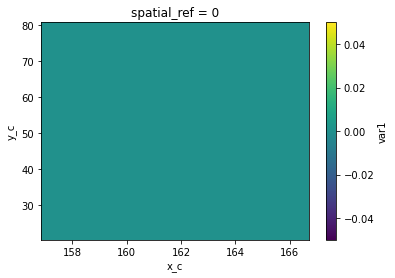

In [153]:

# create xarray object with these lat/lons as the grid cell centers
ds = xr.Dataset(coords={'y_c': (['y_c',], lat),'x_c': (['x_c',], lon)})

# create blank array so rioxarray will reproject properly - yes this has ot be done - also note it can only do one variable at a time
ds['var1'] = (('y_c', 'x_c'), np.zeros((len(lat), len(lon))))

# set spatial dimensions for rioxarray
ds = ds.rio.set_spatial_dims(y_dim='y_c', x_dim='x_c', inplace=True)

# write the rio crs for rioxarray
ds = ds.rio.write_crs("EPSG:4326")

ds.var1.plot()


## Reproject to lambert conformal

In [154]:

xds_lonlat = ds.rio.reproject("+proj=lcc +lon_0=-90 +lat_1=40 +lat_2=60")
xds_lonlat


<xarray.Dataset>
Dimensions:      (x: 1771, y: 375)
Coordinates:
  * x            (x) float64 -8.63e+06 -8.626e+06 ... -1.625e+06 -1.621e+06
  * y            (y) float64 1.131e+07 1.131e+07 1.13e+07 ... 9.834e+06 9.83e+06
    spatial_ref  int64 0
Data variables:
    var1         (y, x) float64 -9.999e+03 -9.999e+03 ... -9.999e+03 -9.999e+03
Attributes:
    grid_mapping:  spatial_ref

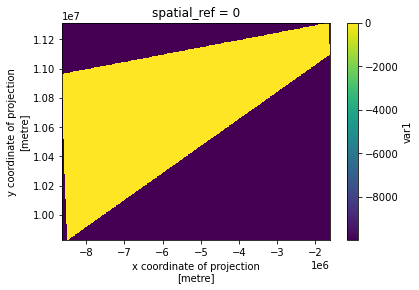

In [155]:
xds_lonlat.var1.plot()

## Reproject back to epsg 4326

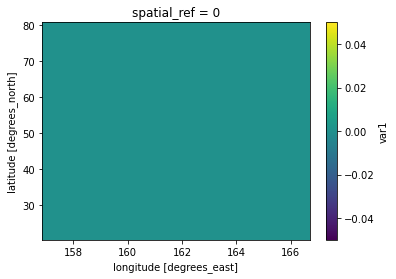

In [156]:
xds_backto_4326 = ds.rio.reproject("EPSG:4326")

xds_backto_4326.var1.plot()

## Create corners

In [158]:
lon = np.linspace(np.min(nep7.x[-1,].values), np.max(nep7.x[-1,].values), len(nep7.x[-1,].values))
lat = np.linspace(np.min(nep7.y[:,-1].values), np.max(nep7.y[:,-1].values), len(nep7.y[:,-1].values))

# create corners from the approximate difference between values 
lonq = lon + np.append(np.diff(lon), np.diff(lon)[-1])
latq = lat + np.append(np.diff(lat), np.diff(lat)[-1])

# add corners to dataset - idea, would be need a separate rioxarray object to reproject corner points here? 
# we are only able to specify 2 spatial dimensions, which means corners get left out during reprojection.
# therefore, we would likely just need to add another dimension for it to work. 
ds = xr.Dataset(coords={'y': (['y',], lat), 'yq' : (['yq',], latq), 'x': (['x',], lon), 'xq': ((['xq',], lonq))})
ds

<xarray.Dataset>
Dimensions:  (x: 685, xq: 685, y: 1633, yq: 1633)
Coordinates:
  * y        (y) float64 20.29 20.32 20.36 20.4 ... 80.65 80.69 80.72 80.76
  * yq       (yq) float64 20.32 20.36 20.4 20.44 ... 80.69 80.72 80.76 80.8
  * x        (x) float64 156.8 156.9 156.9 156.9 ... 166.7 166.7 166.7 166.7
  * xq       (xq) float64 156.9 156.9 156.9 156.9 ... 166.7 166.7 166.7 166.7
Data variables:
    *empty*

In [159]:
import numpy

# redfine values for grid metric computation
PI_180 = np.pi/180.
dx = len(ds.x.values)
dy = len(ds.y.values)

x = ds.x.values
y = ds.y.values
R = 6370.e3 # Radius of sphere        
lon0 = np.float(np.abs((np.max(ds.x.values) + np.min(nep7.x))) / 2)
lat0=np.float(np.abs((np.max(ds.y.values) - np.min(nep7.y))) / 2)
tilt=0
refine=1

# generate regional spherical
lonGrid, latGrid = generate_regional_spherical(lon0=lon0, lon_span=dx, lat0=lat0, lat_span=dy, tilt=tilt, refine=refine)
lonGrid


# redfine values for grid metric computation
(nxp, nyp) = lonGrid.shape
grid_x= lonGrid
grid_y = latGrid


<ipython-input-159-5c0a9f219a53>:11: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  lon0 = np.float(np.abs((np.max(ds.x.values) + np.min(nep7.x))) / 2)
<ipython-input-159-5c0a9f219a53>:12: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  lat0=np.float(np.abs((np.max(ds.y.values) - np.min(nep7.y))) / 2)


In [160]:
# Make a copy of the lon grid as values are changed for computation
lon = grid_x.copy()
lat = grid_y
        
        # Approximate edge lengths as great arcs
grid_dx  = R * angle_through_center( (lat[ :,1:],lon[ :,1:]), (lat[:  ,:-1],lon[:  ,:-1]) )
grid_dy = R * angle_through_center( (lat[1:, :],lon[1:, :]), (lat[:-1,:  ],lon[:-1,:  ]) )

# Scaling by latitude?
cos_lat = np.cos(np.radians(lat))

# Presize the angle_dx array
angle_dx = np.zeros(lat.shape)
# Fix lon so they are 0 to 360 for computation of angle_dx
lon = np.where(lon < 0., lon+360, lon)
angle_dx[:,1:-1] = np.arctan2( (lat[:,2:] - lat[:,:-2]) , ((lon[:,2:] - lon[:,:-2]) * cos_lat[:,1:-1]) )
angle_dx[:, 0  ] = np.arctan2( (lat[:, 1] - lat[:, 0 ]) , ((lon[:, 1] - lon[:, 0 ]) * cos_lat[:, 0  ]) )
angle_dx[:,-1  ] = np.arctan2( (lat[:,-1] - lat[:,-2 ]) , ((lon[:,-1] - lon[:,-2 ]) * cos_lat[:,-1  ]) )

# calculate area
area = R * R * quad_area(lat, lon)

# add row to area to match size of dataset - just duplicate last row - also np.resize could be used here. 
area = np.vstack([area,area[-1,:]])

In [161]:
# resize angle so they are equal
angle_dx = np.resize(angle_dx, area.shape)


In [162]:
# append last area to final value

ds['area'] = (('y', 'x'), area)
ds['angle_dx'] = (('y', 'x'), angle_dx)

In [163]:
# set spatial dimensions again
# set spatial dimensions for rioxarray
ds = ds.rio.set_spatial_dims(y_dim='y', x_dim='x', inplace=True)

# write the rio crs for rioxarray
ds = ds.rio.write_crs("EPSG:4326")

## Bathymetry Data

In [164]:
# now load in the bathymetry dataset and clip it using xarray
# using gebco 2020 data from https://www.gebco.net/data_and_products/gridded_bathymetry_data/
bath = xr.open_dataset("/Users/james/Downloads/gebco_2020_netcdf/GEBCO_2020.nc")


In [165]:
# slice dataset 
bath = bath.sel(lon=slice(np.min(ds.x.values), np.max(ds.x.values)), lat=slice(np.min(ds.y.values), np.max(ds.y.values)))

# change names from lat lon to x y to match
bath = bath.rename({"lon" : "x", "lat" : "y"})

In [166]:

# set spatial dimensions for rioxarray
bath = bath.rio.set_spatial_dims(y_dim='y', x_dim='x', inplace=True)

# write the rio crs for rioxarray
bath = bath.rio.write_crs("EPSG:4326")

In [167]:
# use rioxarray match to add in bathymetry

In [168]:

# reproject match - Reproject a DataArray object to match the resolution, projection, and region of another DataArray.
bath_match = bath.rio.reproject_match(ds)

In [169]:
bath_match

<xarray.Dataset>
Dimensions:      (x: 685, y: 1633)
Coordinates:
  * x            (x) float64 156.8 156.9 156.9 156.9 ... 166.7 166.7 166.7 166.7
  * y            (y) float64 20.29 20.32 20.36 20.4 ... 80.65 80.69 80.72 80.76
    spatial_ref  int64 0
Data variables:
    elevation    (y, x) int16 -9999 -9999 -9999 -9999 ... -2775 -2775 -2775
Attributes:
    Conventions:   CF-1.6
    title:         The GEBCO_2020 Grid - a continuous terrain model for ocean...
    institution:   On behalf of the General Bathymetric Chart of the Oceans (...
    source:        The GEBCO_2020 Grid is the latest global bathymetric produ...
    history:       Information on the development of the data set and the sou...
    references:    DOI: 10.5285/a29c5465-b138-234d-e053-6c86abc040b9
    comment:       The data in the GEBCO_2020 Grid should not be used for nav...
    node_offset:   1.0
    grid_mapping:  spatial_ref

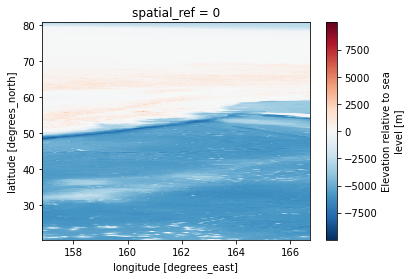

In [170]:
bath_match.elevation.plot()

In [171]:
# add bathymetry
ds['bath'] = (('y', 'x'),bath_match.elevation)

In [172]:
ds

<xarray.Dataset>
Dimensions:      (x: 685, xq: 685, y: 1633, yq: 1633)
Coordinates:
  * y            (y) float64 20.29 20.32 20.36 20.4 ... 80.65 80.69 80.72 80.76
  * yq           (yq) float64 20.32 20.36 20.4 20.44 ... 80.69 80.72 80.76 80.8
  * x            (x) float64 156.8 156.9 156.9 156.9 ... 166.7 166.7 166.7 166.7
  * xq           (xq) float64 156.9 156.9 156.9 156.9 ... 166.7 166.7 166.7
    spatial_ref  int64 0
Data variables:
    area         (y, x) float64 1.077e+09 1.077e+09 ... 1.292e+09 1.292e+09
    angle_dx     (y, x) float64 2.777 2.767 2.747 2.727 ... 1.281 1.297 1.314
    bath         (y, x) int16 -9999 -9999 -9999 -9999 ... -2775 -2775 -2775
Attributes:
    grid_mapping:  spatial_ref